In [1]:
# Importing model
import sys
sys.path.append("..")
from jnk3_noask1.model_analysis.jnk3_no_ask1 import model
from simplepso.pso import PSO
from pysb.simulator import ScipyOdeSimulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from jnk3_noask1.model_analysis.equilibration_function import pre_equilibration

/Users/dionisio/anaconda/envs/nicole/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading data
exp_data = pd.read_csv('../data/exp_data_arrestin_normalization_1h_138max.csv') # [0,1] range normalization

In [3]:
# Indices of model parameters that are going to be calibrated
idx_pars_calibrate = [1, 15, 17, 19, 24, 25, 26, 27]
rates_of_interest_mask = [i in idx_pars_calibrate for i, par in enumerate(model.parameters)]

In [4]:
# Index of Initial conditions of Arrestin
arrestin_idx = [32]
jnk3_initial_value = 0.6  # total jnk3
jnk3_initial_idxs = [35, 36, 37]

param_values = np.array([p.value for p in model.parameters])
nominal_values = np.array([p.value for p in model.parameters])
xnominal = np.log10(nominal_values[rates_of_interest_mask])
lower = xnominal - 2
upper = xnominal + 2
lower[0] = xnominal[0] - np.log10(534)
upper[0] = xnominal[0] + np.log(534)

ignore = 1

In [5]:
# Setting the solver
tspan = np.linspace(0, exp_data['Time (secs)'].values[-(ignore+1)], 121)
t_exp_mask = [idx in exp_data['Time (secs)'].values[:-1] for idx in tspan]
solver = ScipyOdeSimulator(model, tspan=tspan)

In [6]:
# Display function to compare between the experimental data and 
# the simulated trajectories

def display(position):
    Y = np.copy(position)
    param_values[rates_of_interest_mask] = 10 ** Y

    pars1 = np.copy(param_values)
    pars2 = np.copy(param_values)

    # Pre-equilibration
    time_eq = np.linspace(0, 30, 30)
    pars_eq1 = np.copy(param_values)
    pars_eq2 = np.copy(param_values)

    pars_eq2[arrestin_idx] = 0
    pars_eq2[jnk3_initial_idxs] = [0.492, 0.108, 0]

    all_pars = np.stack((pars_eq1, pars_eq2))
    all_pars[:, [24, 25]] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc = pre_equilibration(model, time_eq, all_pars)[1]

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    pars2[arrestin_idx] = 0
    pars2[jnk3_initial_idxs] = [0.492, 0.108, 0]
    sim = solver.run(param_values=[pars1, pars2], initials=eq_conc).all

    plt.plot(tspan, sim[0]['pTyr_jnk3'] / jnk3_initial_value, color='red', label='p(Tyr)JNK3 sim')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pTyr_arrestin_avg'].values[:-ignore],
                 exp_data['pTyr_arrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='red', label='p(Tyr)JNK3 exp')
    plt.plot(tspan, sim[0]['pThr_jnk3'] / jnk3_initial_value, color='blue', label='p(Thr)JNK3 sim')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pThr_arrestin_avg'].values[:-ignore],
                 exp_data['pThr_arrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='blue', label='p(Thr)JNK3 exp')


    plt.plot(tspan, sim[1]['pTyr_jnk3'] / jnk3_initial_value, color='black', label='p(Tyr)JNK3 -Arr sim')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pTyr_noarrestin_avg'].values[:-ignore],
                 exp_data['pTyr_noarrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='black', label='p(Tyr)JNK3 -Arr exp')
    plt.plot(tspan, sim[1]['pThr_jnk3'] / jnk3_initial_value, color='green', label='p(Thr)JNK3 -Arr sim')
    plt.errorbar(exp_data['Time (secs)'].values[:-ignore], exp_data['pThr_noarrestin_avg'].values[:-ignore],
                 exp_data['pThr_noarrestin_std'].values[:-ignore],
                 linestyle='None', marker='o', capsize=5, color='green', label='p(Thr)JNK3 -Arr exp')

    plt.xlabel('Arrestin (microM)')
    plt.ylabel('pJNK3 (microM)')
    plt.legend()
    plt.savefig('jnk3_noASK1_trained_pso_1h.png')
    plt.show()

In [7]:
# Sum of squared errors function to measure the difference between
# the experimental data and the simulated trajectories
def likelihood(position):
    Y = np.copy(position)
    param_values[rates_of_interest_mask] = 10 ** Y

    pars1 = np.copy(param_values)
    pars2 = np.copy(param_values)

    # Pre-equilibration
    time_eq = np.linspace(0, 30, 30)
    pars_eq1 = np.copy(param_values)
    pars_eq2 = np.copy(param_values)

    pars_eq2[arrestin_idx] = 0
    pars_eq2[jnk3_initial_idxs] = [0.492, 0.108, 0]

    all_pars = np.stack((pars_eq1, pars_eq2))
    all_pars[:, [24, 25]] = 0  # Setting catalytic reactions to zero for pre-equilibration
    eq_conc = pre_equilibration(model, time_eq, all_pars)[1]

    # Simulating models with initials from pre-equilibration and parameters for condition with/without arrestin
    pars2[arrestin_idx] = 0
    pars2[jnk3_initial_idxs] = [0.492, 0.108, 0]
    sim = solver.run(param_values=[pars1, pars2], initials=eq_conc).all

    e_mkk4 = np.sum((exp_data['pTyr_arrestin_avg'].values[:-ignore] - sim[0]['pTyr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                    (2 * exp_data['pTyr_arrestin_std'].values[:-ignore])) / len(exp_data['pTyr_arrestin_std'].values[:-ignore])
    e_mkk7 = np.sum((exp_data['pThr_arrestin_avg'].values[:-ignore] - sim[0]['pThr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                    (2 * exp_data['pThr_arrestin_std'].values[:-ignore])) / len(exp_data['pThr_arrestin_std'].values[:-ignore])
    error1 = e_mkk4 + e_mkk7

    e2_mkk4 = np.sum((exp_data['pTyr_noarrestin_avg'].values[:-ignore] - sim[1]['pTyr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                    (2 * exp_data['pTyr_noarrestin_std'].values[:-ignore])) / len(exp_data['pTyr_noarrestin_std'].values[:-ignore])
    e2_mkk7 = np.sum((exp_data['pThr_noarrestin_avg'].values[:-ignore] - sim[1]['pThr_jnk3'][t_exp_mask] / jnk3_initial_value) ** 2 /
                    (2 * exp_data['pThr_noarrestin_std'].values[:-ignore])) / len(exp_data['pThr_noarrestin_std'].values[:-ignore])
    error2 = e2_mkk4 + e2_mkk7
    error = error1 + error2
    return error,

iteration	best    	avg         	std         	min         	max         
         	0.231887	[3.87836607]	[2.53997009]	[0.23188664]	[9.38968681]
         	0.212768	[3.13661042]	[2.32510007]	[0.2127684] 	[7.81319393]
         	0.206896	[2.41979013]	[2.11703452]	[0.20689564]	[6.46948251]
         	0.184986	[1.89349751]	[1.83845539]	[0.18498643]	[5.61879889]
         	0.184986	[1.45164385]	[1.57471634]	[0.19178489]	[5.08961144]
         	0.164461	[1.11181163]	[1.27300363]	[0.16446109]	[4.57414652]
         	0.156144	[0.70905316]	[0.86565091]	[0.15614434]	[3.67879558]
         	0.150069	[0.48451]   	[0.55055366]	[0.15006917]	[2.22861584]
         	0.148348	[0.28830832]	[0.24429412]	[0.14834802]	[1.1234503] 
         	0.142992	[0.21410813]	[0.06325478]	[0.1429924] 	[0.38728816]
         	0.13638 	[0.183673]  	[0.03425689]	[0.13638006]	[0.26207961]
         	0.13638 	[0.18882925]	[0.03528044]	[0.1397482] 	[0.26332706]
         	0.13638 	[0.17338114]	[0.0394015] 	[0.13697802]	[0.30138798]
      

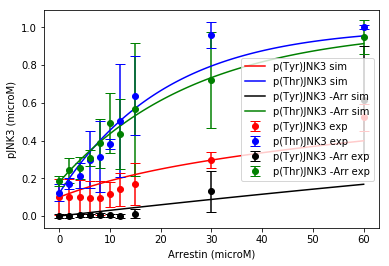

In [8]:
# Running the Particle Swarm Optimization algorithm
pso = PSO(save_sampled=False, verbose=True, num_proc=4)
pso.set_cost_function(likelihood)
pso.set_start_position(xnominal)
pso.set_bounds(2)
pso.set_speed(-.25, .25)
pso.run(25, 100)
display(pso.best)
